In [1]:
from sqlalchemy import create_engine
from sqlalchemy.inspection import inspect
from declare_db import Base, Info, Item
from sqlalchemy.orm import sessionmaker
from collections import defaultdict
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
db_name = "exchange.db"
engine_name = 'sqlite:///exchange.db'

def query_to_dict(rset):
    result = defaultdict(list)
    for obj in rset:
        instance = inspect(obj)
        for key, x in instance.attrs.items():
            result[key].append(x.value)
    return result

In [3]:
engine = create_engine(engine_name)
Base.metadata.bind = engine

DBSession = sessionmaker(bind=engine)
session = DBSession()

In [42]:
mats = session.query(Info).join(Item, Info.item_name==Item.info_name).filter(Item.item_type=='Mat').all()
df = pd.DataFrame(query_to_dict(mats)).set_index('id')

In [85]:
# Remove data with 'too high' deviation from mean; this could be dirty
def cleandata(df):
    clean = df.copy()
    clean['datetime'] = pd.to_datetime(clean['timestamp'], unit='s')
    price_mean = clean['price'].groupby(df['item_name']).mean().astype('int64').rename('avg_price')
    price_std = clean['price'].groupby(df['item_name']).std().rename('std_price')
    clean = clean.join(price_mean, on='item_name')
    clean = clean.join(price_std, on='item_name')
    clean = clean[(abs(clean['price'])/abs(clean['avg_price'])>0.2) & (abs(clean['price'])/abs(clean['avg_price'])<5)]
    return clean

In [46]:
df = cleandata(df)

In [47]:
df.head(5)

,item_name,timestamp,price,volume,datetime,avg_price,std_price
id,,,,,,,
357,raccoon_leaf,1547095672,216635,202,2019-01-10 04:47:52,187600,40730.69941
356,raccoon_leaf,1547106291,238299,112,2019-01-10 07:44:51,187600,40730.69941
355,raccoon_leaf,1547117529,238299,323,2019-01-10 10:52:09,187600,40730.69941
354,raccoon_leaf,1547129055,261486,934,2019-01-10 14:04:15,187600,40730.69941
353,raccoon_leaf,1547144284,284288,3334,2019-01-10 18:18:04,187600,40730.69941


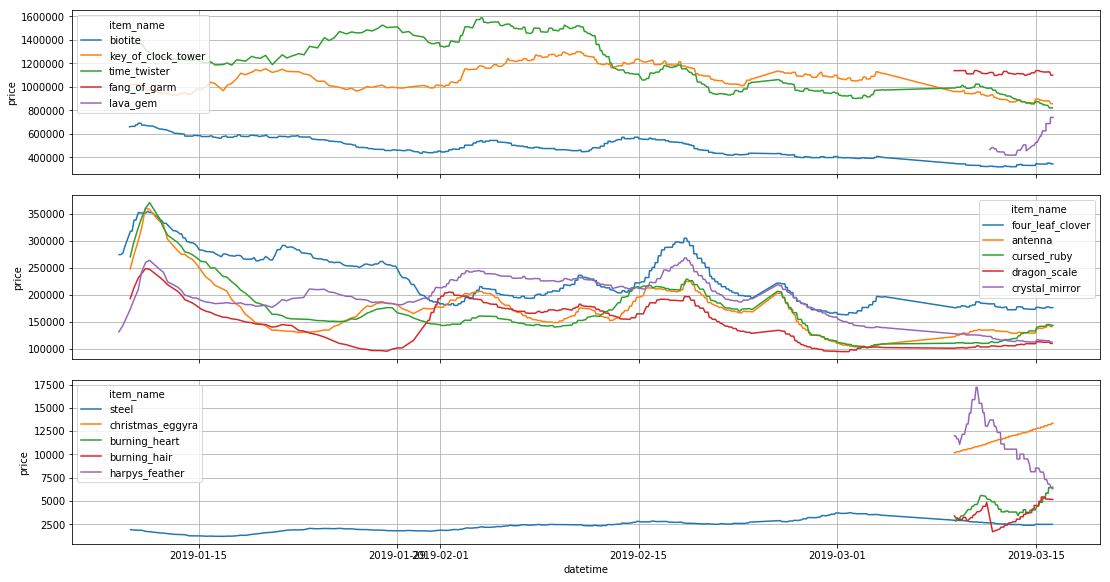

In [48]:
high = df[(df['avg_price'] > 300000)].sort_values(by=['std_price'], ascending=False)['item_name'].unique()[:5]
mid = df[(df['avg_price'] > 20000) & (df['avg_price'] <= 300000)].sort_values(by=['std_price'], ascending=False)['item_name'].unique()[:5]
low = df[(df['avg_price'] > 1000) & (df['avg_price'] <= 20000)].sort_values(by=['std_price'], ascending=False)['item_name'].unique()[:5]

high_mats = df[df['item_name'].isin(top)]
mid_mats = df[df['item_name'].isin(mid)]
low_mats = df[df['item_name'].isin(low)]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(15,8))
plt.tight_layout()
sns.lineplot(data=high_mats[['item_name', 'price', 'datetime']], x='datetime', y='price', hue='item_name', ax=ax1)
sns.lineplot(data=mid_mats[['item_name', 'price', 'datetime']], x='datetime', y='price', hue='item_name', ax=ax2)
sns.lineplot(data=low_mats[['item_name', 'price', 'datetime']], x='datetime', y='price', hue='item_name', ax=ax3)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
plt.show()

In [51]:
def process_df(df):
    processed = df.copy()
    processed['date'] = processed['datetime'].dt.date
    processed = processed.groupby(['item_name', 'date'])['price', 'volume', 'avg_price'].mean().astype('int64')
    return processed

In [52]:
matsdf = pd.DataFrame(query_to_dict(mats))
df = cleandata(matsdf)
df = process_df(df).reset_index()

In [53]:
ant = df[df['item_name']=='antenna']
pearl = df[df['item_name']=='pearl']
print(ant.tail(5))
print(pearl.tail(5))

   item_name        date   price  volume  avg_price
81   antenna  2019-03-12  132979   30105     166656
82   antenna  2019-03-13  129871   28187     166656
83   antenna  2019-03-14  129710   25265     166656
84   antenna  2019-03-15  139605   21596     166656
85   antenna  2019-03-16  141277   20386     166656
     item_name        date  price  volume  avg_price
1570     pearl  2019-03-12  80365   41454     102106
1571     pearl  2019-03-13  82799   38640     102106
1572     pearl  2019-03-14  86111   38765     102106
1573     pearl  2019-03-15  89041   40070     102106
1574     pearl  2019-03-16  88752   39590     102106


In [54]:
df['item_name'].unique()

array(['abyss_flower', 'agate', 'amethyst', 'antenna', 'aquamarine',
       'armor_shard', 'bell', 'biotite', 'black_dyestuffs', 'bloody_rune',
       'box_wrapper', 'brigan', 'broken_blade', 'brown_dyestuffs',
       'burning_hair', 'burning_heart', 'cat_grass', 'christmas_eggyra',
       'christmas_garland', 'christmas_socks', 'coal',
       'cobaltblue_dyestuffs', 'crystal_bone', 'crystal_mirror',
       'cursed_ruby', 'cyfar', 'dog_teeth', 'dragon_scale', 'emperium',
       'evil_horn', 'fabric', 'fang_of_garm', 'feather', 'fire_crystal',
       'flame', 'four_leaf_clover', 'frozen_heart', 'frozen_rose',
       'garlet', 'glass_bead', 'glitter_shell', 'glow_metal', 'gold_sand',
       'green_dyestuffs', 'hand_of_god', 'hard_skin', 'harpys_feather',
       'heroic_emblem', 'ice_cube', 'ice_powder', 'immortal_heart',
       'iron', 'jellopy', 'key_of_clock_tower', 'lava_gem',
       'lemegeton_fur', 'lemegeton_tear', 'lemon_dyestuffs',
       'light_granule', 'mandragora', 'memento',

In [63]:
pd.to_datetime('now').date() - pd.to_timedelta(15, unit='d')

datetime.date(2019, 3, 1)

In [78]:
def plot_stats(data, period):
    today = pd.to_datetime('now').date()
    cutoff = today - pd.to_timedelta(period, unit='d')
    data = data[data['date'] >= cutoff]
    
    fig, ax1 = plt.subplots(figsize=(8, 6))
    plt.xticks(rotation=45)
    ax2 = ax1.twinx()
    ax1.bar(data['date'].apply(mdates.date2num), data['volume'], color=(190/255,190/255,190/255,0.7), label='Volume')
    ax2.plot(data['date'].apply(mdates.date2num), data['price'], label='Price', marker='o')

    # handle the legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    # Fix the date format on x-axis
    myFmt = mdates.DateFormatter('%Y-%m-%d')
    ax1.xaxis.set_major_formatter(myFmt)
    
    # Align the 2 y-axis
    #ax1.set_yticks(np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))
    #ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))

    # bells and whistles
    ax1.set_title(data.iloc[0]['item_name'], size=20)
    ax1.set_ylabel('Volume', size=15)
    ax2.set_ylabel('Price', size=15)
    ax2.grid(True)

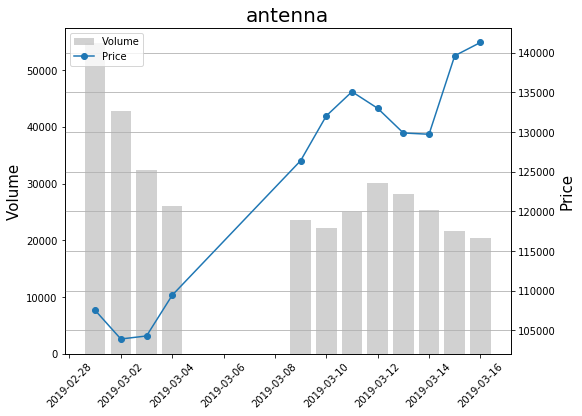

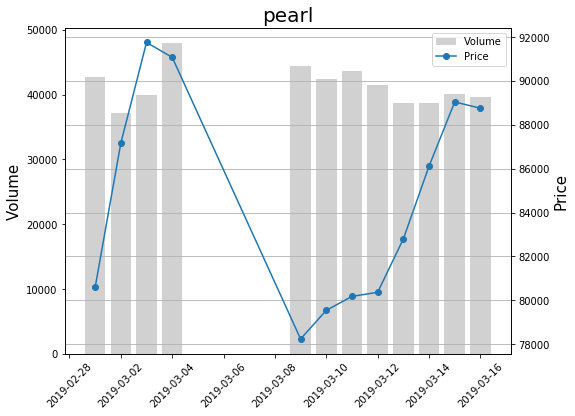

In [79]:
mats = [ant, pearl]
for mat in mats:
    plot_stats(mat, 15)

'''
for i in plt.get_fignums():
    plt.figure(i)
    plt.savefig('figure%d.png' % i)
'''

plt.show()

In [88]:
cards = session.query(Info).join(Item, Info.item_name==Item.info_name).filter(Item.item_type=='Card').all()
df = pd.DataFrame(query_to_dict(cards))
df = cleandata(df)
df = process_df(df).reset_index()

In [89]:
slots = [x[0] for x in session.query(Item.slot).filter(Item.item_type=='Card').distinct().all()]
for slot in slots:
    print(slot)
    c = (session.query(Info).join(Item, Info.item_name==Item.info_name)
             .filter(Item.item_type=='Card')
             .filter(Item.slot==slot).all())
    df = pd.DataFrame(query_to_dict(c))
    df = cleandata(df)
    df = process_df(df).reset_index()
    print(df.head(5))

Accessory
        item_name        date    price  volume  avg_price
0  anacondaq_card  2019-01-15  3415421       4    3751683
1  anacondaq_card  2019-01-16  2813435       1    3751683
2  anacondaq_card  2019-01-18  3382543       1    3751683
3  anacondaq_card  2019-01-19  3625302       3    3751683
4  anacondaq_card  2019-01-20  3389184       5    3751683
Armor
   item_name        date    price  volume  avg_price
0  agav_card  2019-01-10  7950366      43    6723605
1  agav_card  2019-01-11  7864974      67    6723605
2  agav_card  2019-01-12  7203921     123    6723605
3  agav_card  2019-01-13  6669065      82    6723605
4  agav_card  2019-01-14  6518604      65    6723605
Footgear
    item_name        date   price  volume  avg_price
0  alarm_card  2019-01-10  850355     503    1109515
1  alarm_card  2019-01-11  776422     498    1109515
2  alarm_card  2019-01-12  722622     660    1109515
3  alarm_card  2019-01-13  693417     639    1109515
4  alarm_card  2019-01-14  676646     704   

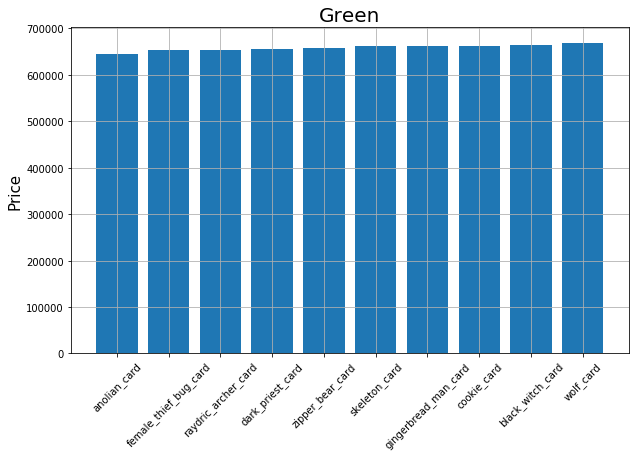

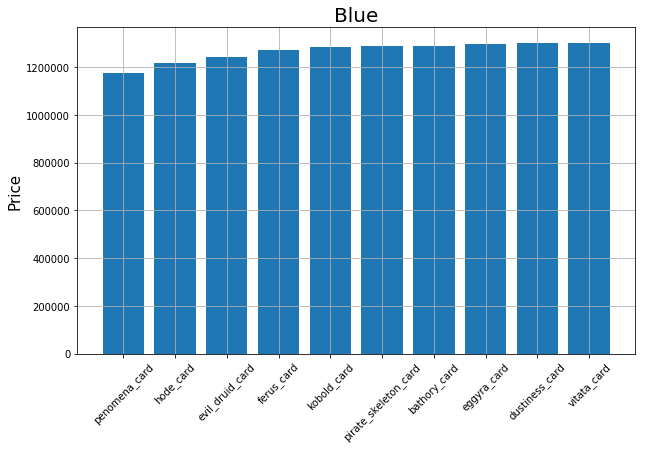

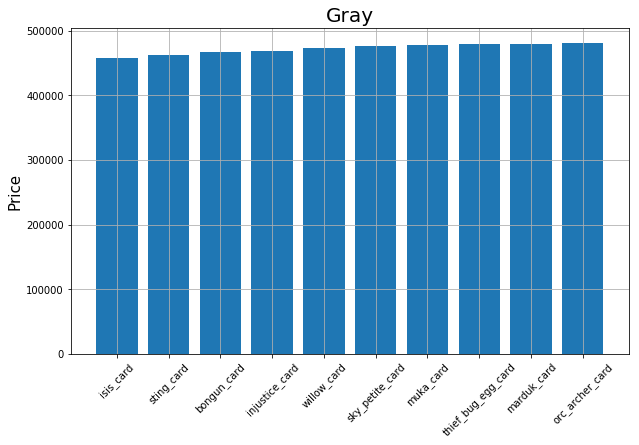

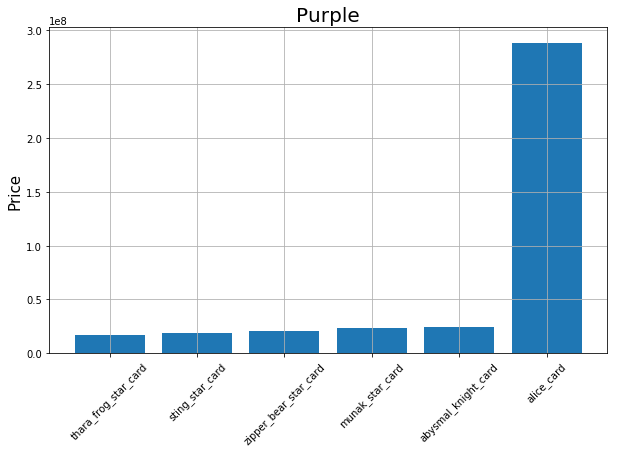

In [99]:
rarity = [x[0] for x in session.query(Item.rarity).filter(Item.item_type=='Card').distinct().all()]
for r in rarity:
    if r == '':
        continue
    c = (session.query(Info).join(Item, Info.item_name==Item.info_name)
             .filter(Item.item_type=='Card')
             .filter(Item.rarity==r).all())
    df = pd.DataFrame(query_to_dict(c))
    df = cleandata(df)
    df = process_df(df).reset_index()
    plot_multi(df, r)
    #print(df.head(5))

In [98]:
def plot_multi(data, title):
    today = pd.to_datetime('now').date()
    data = data[data['date'] == today].sort_values(by='price')[:10]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=45)
    ax1.bar(data['item_name'], data['price'], label='Prices')

    # bells and whistles
    ax1.set_title(title, size=20)
    ax1.set_ylabel('Price', size=15)
    ax1.grid(True)